In [145]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Classification problem

Dataset: Bock,R.. (2007). MAGIC Gamma Telescope. UCI Machine Learning Repository.
https://doi.org/10.24432/C52C8B.

> *Data Preprocessing*


In [146]:
#importing dataset with the feature labels
cols = ['fLenght', 'fWidht', 'fSize', 'fConc', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
dataset = pd.read_csv('magic04.data', names=cols)

In [147]:
# turning into numerical values the categorical values

dataset['class'].replace(dataset['class'].unique(), [0,1], inplace=True)

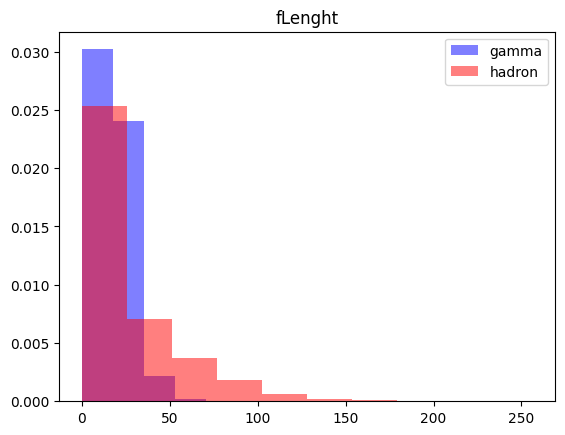

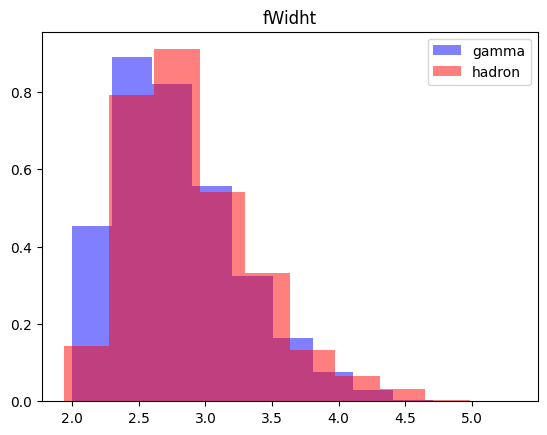

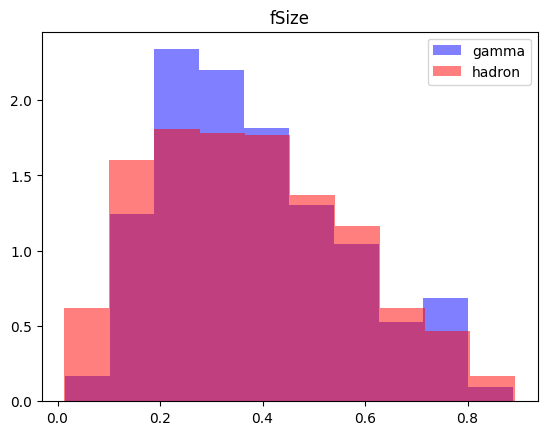

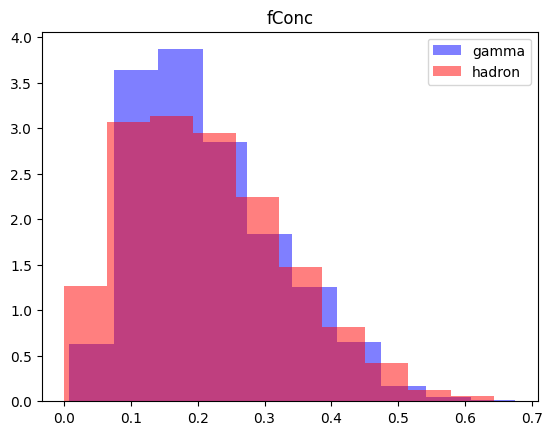

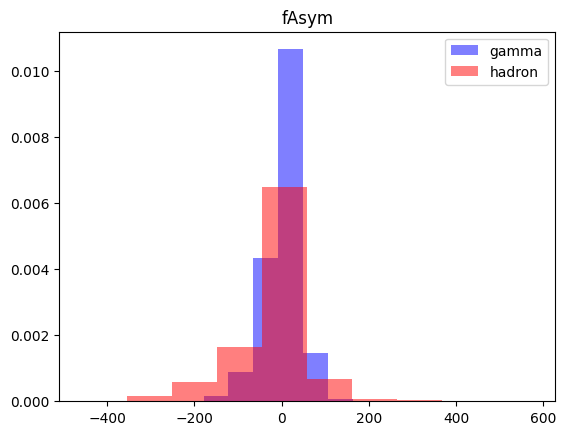

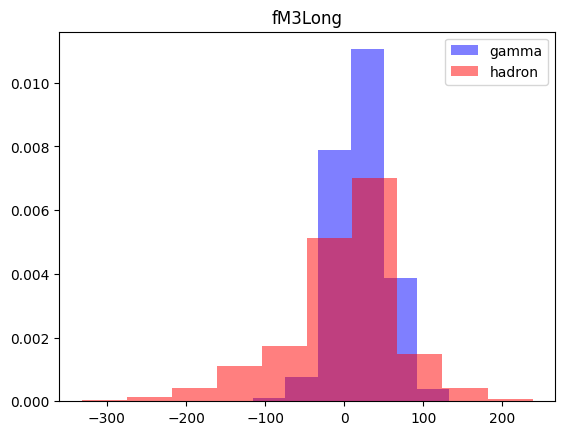

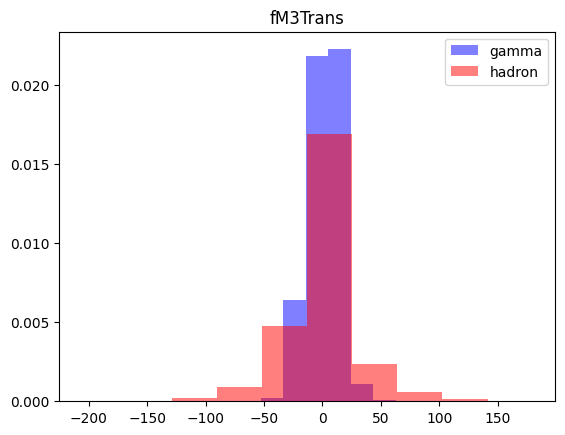

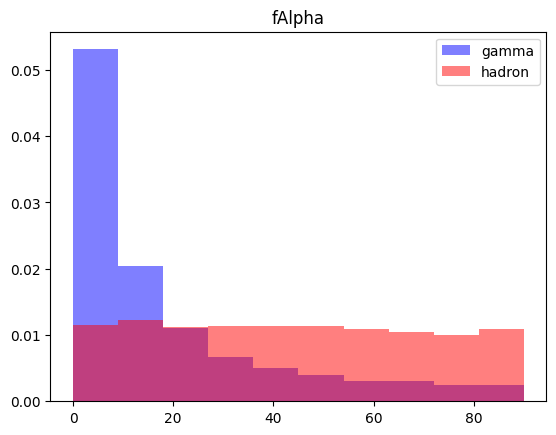

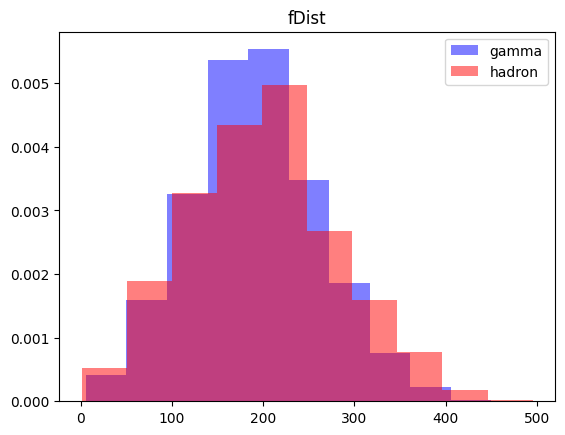

In [148]:
# visualize the data

for label in cols[:-1]:
  plt.hist(dataset[dataset['class']==0][label], color='b', label='gamma', alpha=0.5, density=True)
  plt.hist(dataset[dataset['class']==1][label], color='r', label='hadron', alpha=0.5, density=True)
  plt.title(label)
  plt.legend()
  plt.show()

In [149]:
# split into features and label

X = dataset.drop('class', axis=1) #delete the column 'class'
y = dataset['class']

In [150]:
# normalize the feature set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)
X = pd.DataFrame(x_scaled, columns=cols[:9])  #to return a DataFrame and not a np.array

In [151]:
# split the dataset into training, testing and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)
X_test, X_vali, y_test, y_vali = train_test_split(X_test, y_test, train_size=0.5, random_state=9)

In [152]:
# check if there are imbalances in the training set
from imblearn.under_sampling import RandomUnderSampler

len_class = len(y_train)
len_class1 = len(y_train[y_train==1])
len_class0 = len(y_train[y_train==0])
print(f'Cardinality of the class 1:', len_class1, ', it means the', 100* len_class1/len_class, '%')
print(f'Cardinality of the class 0:', len_class0, ', it means the', 100* len_class0/len_class, '%')

if abs(100* len_class1/len_class - 100* len_class0/len_class) >= 20 :
  print('The sets are imbalanced')
  rus = RandomUnderSampler(random_state=20)
  X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
  X_train = X_resampled
  y_train = y_resampled

Cardinality of the class 1: 4016 , it means the 35.191026989134244 %
Cardinality of the class 0: 7396 , it means the 64.80897301086576 %
The sets are imbalanced


In [153]:
# importance features
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

feature_name = cols[:9]
forest = RandomForestClassifier(random_state = 7)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_name)

In [154]:
importances_a = importances.argsort()
most_important = []
label_important = []
for i in range(3):
  most_important.append(importances[importances_a[-1-i]])
  label_important.append(cols[importances_a[-1-i]])
print(f'The more important features are ', label_important, 'with importance value of ', most_important)

The more important features are  ['fAlpha', 'fLenght', 'fWidht'] with importance value of  [0.2711331020435696, 0.15104256640766855, 0.12910184685755757]


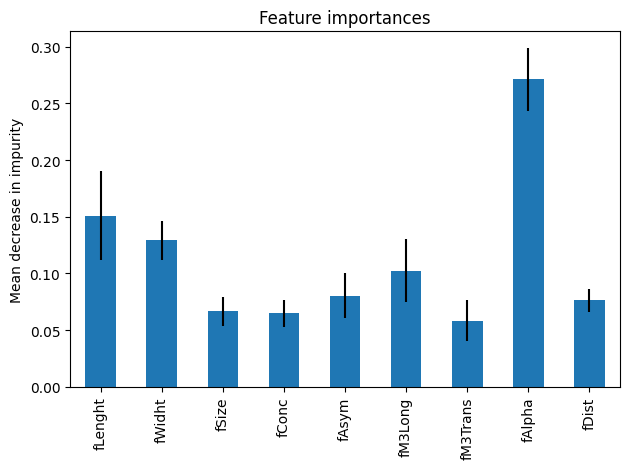

In [155]:
# plot the importances
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

> *Models*

In [173]:
# 1. K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score

knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
score_knn = precision_score(y_test, y_pred)
print(f'The precision score is:', score_knn)

The precision score is: 0.7244973938942666


<Axes: >

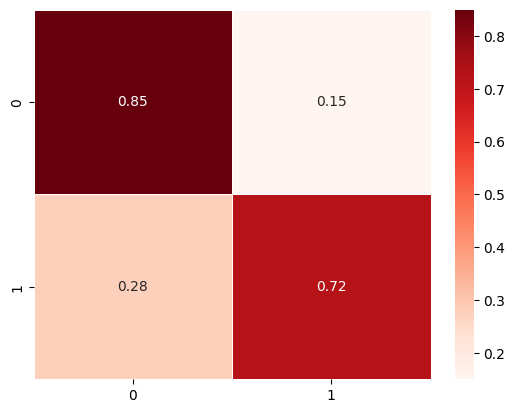

In [171]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(conf, cmap='Reds', annot=True, linewidth=0.5)

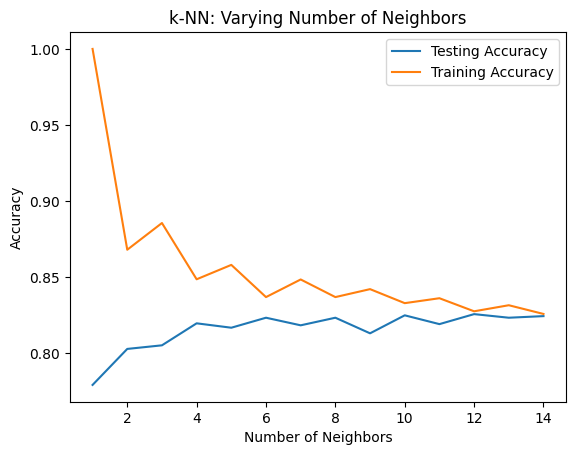

In [169]:
train_accuracy = []
test_accuracy = []
n_neighb = np.arange(1,15)
for i in range(14):
  knn = KNeighborsClassifier(n_neighbors=i+1)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  train_accuracy.append(knn.score(X_train, y_train))
  test_accuracy.append(knn.score(X_test, y_test))

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(n_neighb, test_accuracy, label = 'Testing Accuracy')
plt.plot(n_neighb, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [177]:
# 2. Naive-Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score

nb = GaussianNB()
nb = nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
score_nb = precision_score(y_test, y_pred)
print(f'The precision score is:', score_nb)

The precision score is: 0.7031446540880503


<Axes: >

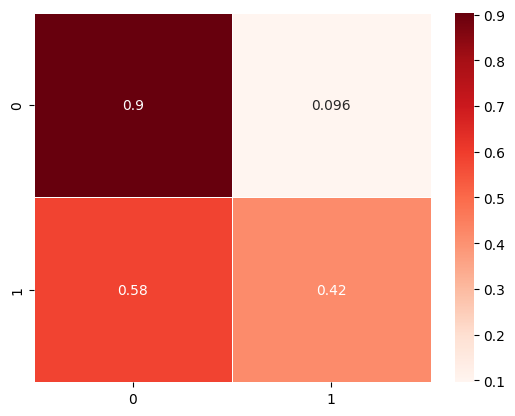

In [176]:
#plot the confusion matrix
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(conf, cmap='Reds', annot=True, linewidth=0.5)

In [181]:
# function to train the model
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

def ModelEsecution(Model, x_train, x_test, y_train, y_test):
  model = Model
  model = model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  score_model = precision_score(y_test, y_pred)

  conf = confusion_matrix(y_test, y_pred, normalize='true')
  sns.heatmap(conf, cmap='Reds', annot=True, linewidth=0.5)
  return score_model

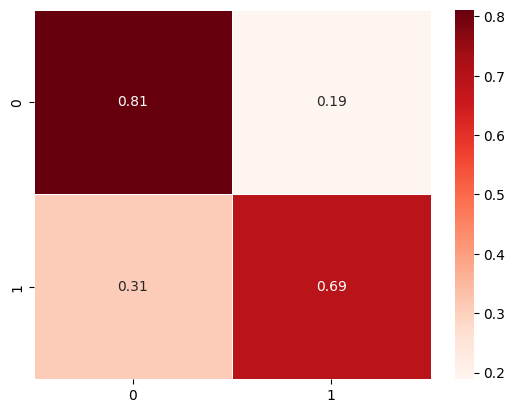

In [183]:
# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_score = ModelEsecution(LogisticRegression(), X_train, X_test, y_train, y_test)